In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import astropy
import numpy as np
import jax
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Angle, EarthLocation
import astropy.units as u
from nsb2.instrument import HESS

from nyx.core.integrator import render
from nyx.core import Observation
from nyx.core.model import Model
from nyx.atmosphere import atmospheres
from nyx.instrument import instruments
from nyx.emitter import zodiacal, airglow, moon, stars

from nyx.core import get_wavelengths

# How to use autograd to fit simulation:

## Build model:

In [3]:
# Instrument:
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

# Atmosphere:
oz = np.genfromtxt('absorption.txt')
oz_wvl, oz_tau = jnp.array(oz[:,0]), -np.log(jnp.array(oz[:,2]))
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        tau_absorption_func=lambda lam, h: jnp.interp(lam, oz_wvl, oz_tau) * jnp.exp(-(h-2.6)/7),
        hg_asymmetry=0.7
        )

# Emitters:
leinert = zodiacal.Leinert1998()
glow = airglow.ESOSkyCalc()
jones = moon.Jones2013()
gaia = stars.GaiaDR3(lim_mag=12)

# Combine to model:
pipeline = Model(HESS1, atmo, [glow, leinert, gaia, jones])

/usr/local/lib/python3.13/site-packages/astropy/units/quantity.py:1865: RuntimeWarning: All-NaN slice encountered
  result = super().__array_function__(function, types, args, kwargs)


## Example observation:

In [4]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-11-14T02:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('crab nebula')
obs = Observation(location, obstime, target, rotation, fov=Angle(3*u.deg))

## Initialize scene:

In [6]:
scene = pipeline.query(obs)
initial_params = scene.get_initial_parameters()
scene.print_parameters(format='table')

┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter    │ Shape │ Initial  │ Current │ Bounds │ Description            │ 
├───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ aod_500      │ (1,)  │ 0.1000   │ -       │ -      │ AOD at 500nm           │ 
│ atmosphere │ atmosphere │ angstrom_exp │ (1,)  │ 1.0000   │ -       │ -      │ Angstrom exponent      │ 
│ atmosphere │ atmosphere │ hg_asymmetry │ (1,)  │ 0.7000   │ -       │ (0, 1) │ HG asymmetry           │ 
│ instrument │ instrument │ eff          │ (1,)  │ 1.0000   │ -       │ -      │ Telescope efficiency   │ 
│ instrument │ instrument │ shift        │ (2,)  │ -        │ -       │ -      │ Pixel shift in rad     │ 
│ emitter_0  │ diffuse    │ sfu          │ (1,)  │ 100.0000 │ -       │ -      │ Solar flux value [SFU] │ 
└──────────────────────────────────────

/home/anonymous/ECAP/nyx/nyx/atmosphere/airmass.py:7: RuntimeWarning: invalid value encountered in scalar power
  return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))


## Creating a target image with shifted coordinates:

Shifting parameters:

In [38]:
shift = np.array([42, 112])

flat_params = initial_params.copy()
start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']
shift_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)

In [39]:
ground_truth = render(scene.realize(shift_params))

# Noisify image:
log_std = np.log(1 + 0.1)
noise = np.random.lognormal(mean=0, sigma=log_std, size=ground_truth.shape)

target_img = jnp.array(ground_truth * noise)

## Create a loss function:

In [48]:
@jax.jit
def loss_fn(shift):
    flat_params = initial_params.copy()
    start, end = scene.parameters['instrument']['parameters']['shift']['flat_indices']
    flat_params = flat_params.at[start:end].set(shift/3600/180*jnp.pi)
    
    scene_instance = scene.realize(flat_params)
    likelihood = (render(scene_instance) - target_img)**2 / (0.1*target_img)
    return jnp.sum(likelihood)

initial_shift = jnp.zeros(2)

loss_and_grad_fn = jax.value_and_grad(loss_fn)
loss, grads = loss_and_grad_fn(initial_shift)

## Use jax optimizer for fast optimization:

In [49]:
import optax
# Start optimizer
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
shift = jnp.zeros(2)  # initial guess
opt_state = optimizer.init(shift)

# Define step
@jax.jit
def loss_step(shift, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(shift)
    updates, opt_state = optimizer.update(grads, opt_state)
    shift = optax.apply_updates(shift, updates)
    return shift, opt_state, loss

# Optimization
for step in range(400):
    shift, opt_state, loss = loss_step(shift, opt_state)
    if step % 50 == 0:
        print(f"Step {step}, loss={loss:.6f}")

print("Optimized shift:", shift)

Step 0, loss=195916775424.000000
Step 50, loss=13979913216.000000
Step 100, loss=13877407744.000000
Step 150, loss=13875643392.000000
Step 200, loss=13875659776.000000
Step 250, loss=13875648512.000000
Step 300, loss=13875634176.000000
Step 350, loss=13875661824.000000
Optimized shift: [ 40.324566 115.01317 ]


## Scan likelihood:

In [50]:
def scan_2d(shift_best, delta=1.0, n_points=30):
    grid = jnp.linspace(-delta, delta, n_points)
    losses = []

    for dx in grid:
        row = []
        for dy in grid:
            s = shift_best.at[0].add(dx).at[1].add(dy)
            loss = float(loss_fn(s))  # convert to host scalar, keeps memory low
            row.append(loss)
        losses.append(row)
    losses = jnp.array(losses)
    return grid, grid, losses

In [51]:
%%time
gridx, gridy, Z = scan_2d(shift, delta=600, n_points=40)

CPU times: user 1min 38s, sys: 327 ms, total: 1min 38s
Wall time: 12.9 s


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_618427/448582632.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.colorbar(label='$\sqrt{\Delta TS}$')


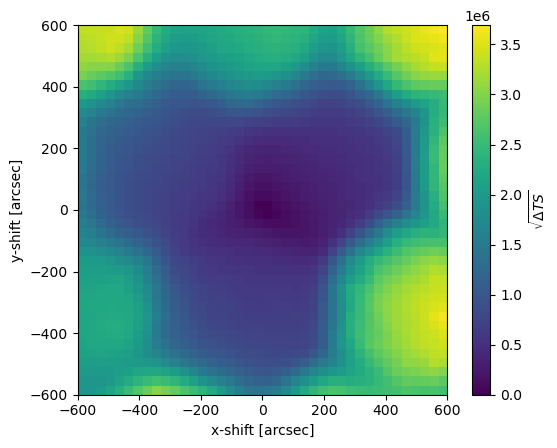

In [59]:
import matplotlib.pyplot as plt
loss_min = jnp.min(Z)
deltaZ = np.sqrt((Z-loss_min))

plt.imshow(deltaZ,extent=[gridx.min(), gridx.max(), gridy.min(), gridy.max()])
plt.xlabel('x-shift [arcsec]')
plt.ylabel('y-shift [arcsec]')

plt.colorbar(label='$\sqrt{\Delta TS}$')